# CS323 Project 5: 3D Deep Learning

<button disabled>

**Authors:** [Guocheng Qian](http://www.gcqian.com) and [Modar Alfadly](http://modar.me) and [Hasan Hammoud](https://cemse.kaust.edu.sa/ece/people/person/hasan-abed-al-kader-hammoud)

**Due Date:** 09 May 2023 @ 11:59 PM

</button>

To setup a conda environment for this project, just run the following commands:

```shell
source $(conda info --base)/etc/profile.d/conda.sh
conda create -n cs3232 python=3.9.2 -y
conda activate cs3232

conda install pytorch=1.8.1 torchvision=0.9.1 torchaudio=0.8.1 cudatoolkit=11.1 -c pytorch -c conda-forge -y
conda install jupyter=1.0.0 -y  # to edit this file
conda install matplotlib=3.3.4 -y  # for plotting
conda install tqdm=4.59.0 -y  # for a nice progress bar
conda install h5py=2.10.0 -y  # H5Py for processing HDF5 files
conda install tensorboard=2.8.0 -c conda-forge -y  # to use tensorboard
pip install pyvista==0.33.2 # for visulizing point cloud
pip install gdown
mamba install pandas -y
mamba install scikit-learn -c conda-forge -y
mamba install pyvista

pip install ftfy regex # for clip
pip install git+https://github.com/openai/CLIP.git # for clip

pip install jupyter_http_over_ws  # for Google Colab
jupyter serverextension enable --py jupyter_http_over_ws  # Google Colab
```

In the previous projects, you learned about discriminative and generative models and used different neural network architectures; MLPs (for generic features), CNNs (for images), RNNs (for feature sequences), and Transformers (for features sets). In this project, you will learn about Graph Convolutional Networks ([GCNs](https://tkipf.github.io/graph-convolutional-networks/)) for tackling graphs (a set of vertices and edges). However, we will use GCNs to do deep learning on point clouds (unstructured non-euclidean data) which is a common representation for geometric data (a set of vertices in 3D). 体素提供了 3D 空间的结构化表示，规则网格允许轻松index , query 和处理数据,   Volume-based operations easy,  而点云则在捕获和表示详细几何体方面提供了灵活性和效率。

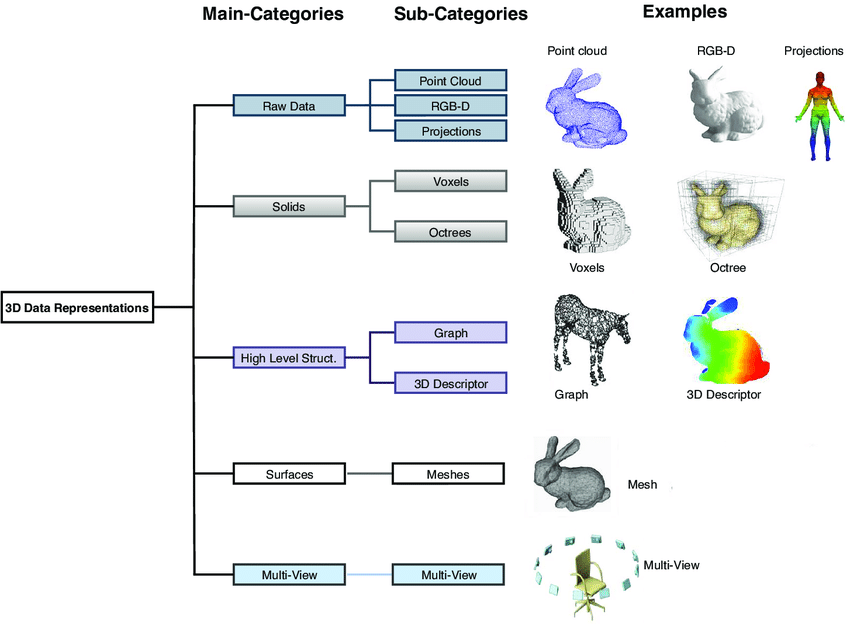

In [2]:
import os
import ssl
import math
import enum
import urllib
from pathlib import Path
import glob

from tqdm.notebook import tqdm

import h5py
import numpy as np
import pandas as pd
import sklearn.metrics as metrics

import tensorboard

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.collect_env import get_pretty_env_info

from torchvision.datasets.utils import extract_archive, check_integrity

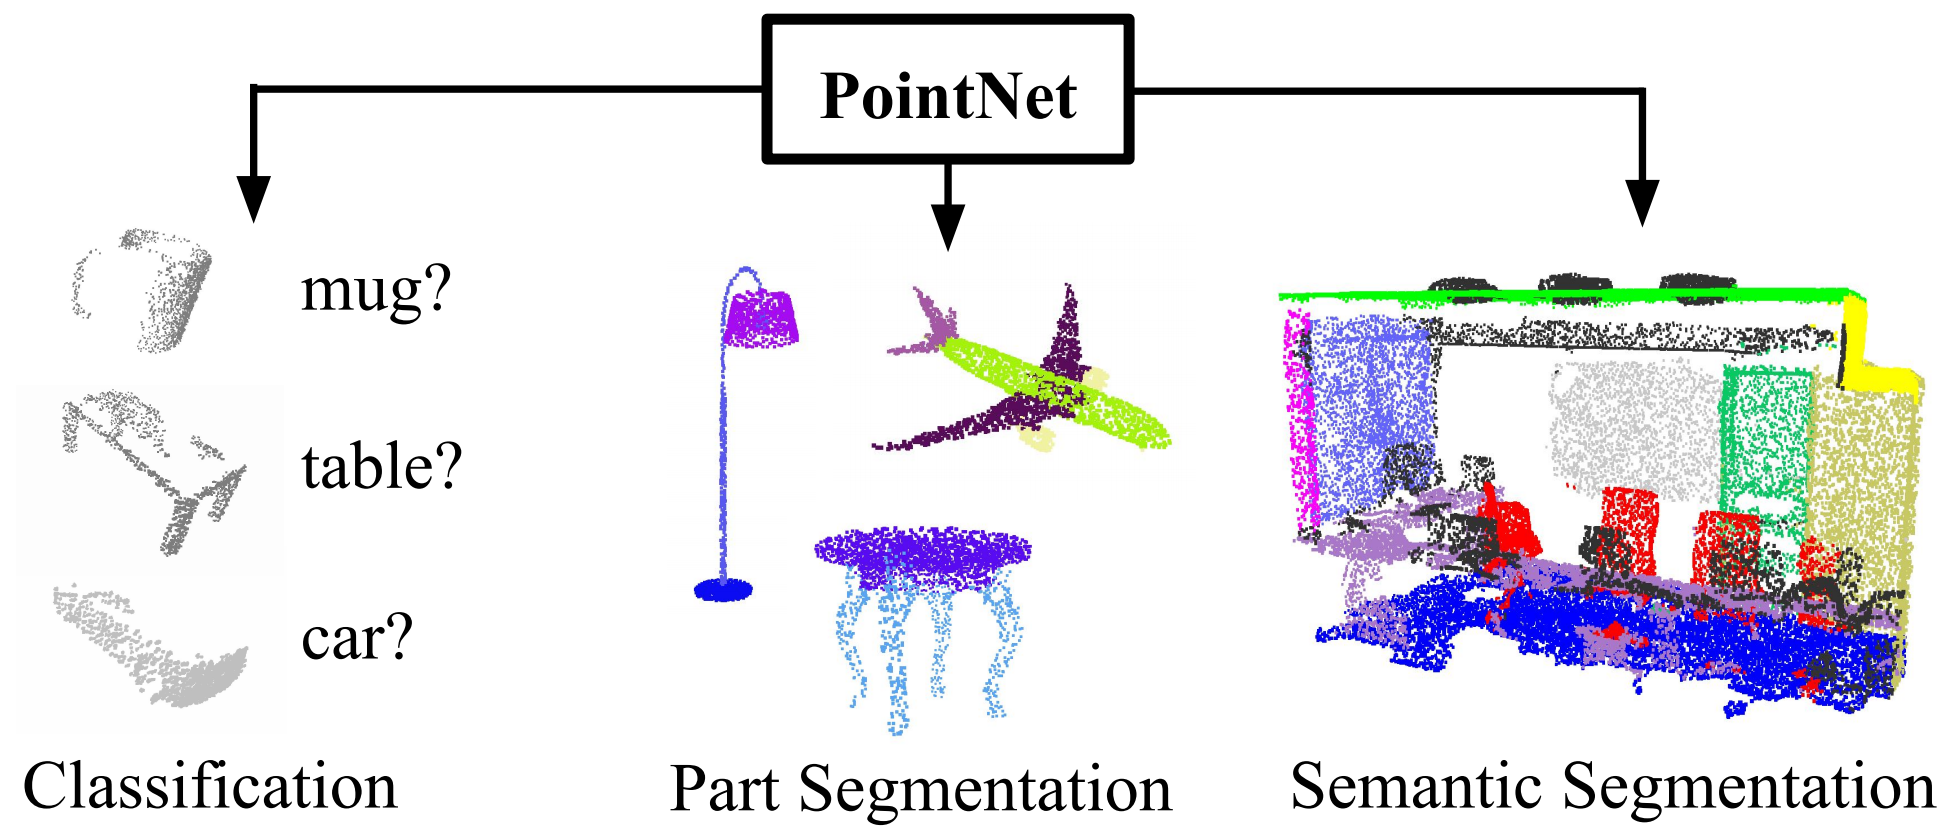

Point clouds are a set of unordered points in 3D space. A network that processes $N$ 3D points needs to be invariant to all possible $N!$ permutations of the points. Therefore, using the plain CNN architecture (like ResNet) is not feasible for this task. In this project, we will introduce two permutation-invariant methods to process point clouds:

- [PointNet](https://arxiv.org/abs/1612.00593) uses shared MLPs to extract per-point features followed by a global pooling operation then a classifier
- [DGCNN](https://arxiv.org/abs/1801.07829) (a.k.a, EdgeConv, a graph-based method) extracts point neighborhoods and apply convolution-like operatoins on them

You will be asked to implement a simplified version of PointNet and the original DGCNN for point cloud classification on [ModelNet40](https://modelnet.cs.princeton.edu/) dataset.

We will do everything with pure PyTorch but using libraries like [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) and [Kaolin](https://github.com/NVIDIAGameWorks/kaolin) can make our lives much easier.

# Part 1: Setup (2 points)

## Task 1: Data Processing (2 points)

ModelNet40 contains $12,311$ meshed CAD models from $40$ classes. We work with sampled point clouds from the surfaces of the meshes. Given a point cloud $R^{N \times C}$ ($N$ is the number of points and $C=3$ is $(x, y, z)$), the goal is to predict which category this point cloud belongs to. From this point forward, we will assume $N = 1024$ to be fixed. In addition, a batch of $B$ point clouds will have the shape $[B, C, N]$.

In [3]:
def download_and_extract_archive(url, path, md5=None):
    # Works even if the SSL certificate is expired for the link
    path = Path(path)
    path.mkdir(parents=True, exist_ok=True)
    extract_path = path
    file_path = path / Path(url).name
    if not file_path.exists() or not check_integrity(file_path, md5):
        print(f'{file_path} not found or corrupted')
        print(f'downloading from {url}')
        context = ssl.SSLContext()
        with urllib.request.urlopen(url, context=context) as response:
            with tqdm(total=response.length) as pbar:
                with open(file_path, 'wb') as file:
                    chunk_size = 1024
                    chunks = iter(lambda: response.read(chunk_size), '')
                    for chunk in chunks:
                        if not chunk:
                            break
                        pbar.update(chunk_size)
                        file.write(chunk)
        extract_archive(str(file_path), str(extract_path))
    return extract_path

def load_data(data_dir, partition, url=None):
    download_and_extract_archive(url, data_dir)
    all_data = []
    all_label = []
    for h5_name in glob.glob(os.path.join(data_dir, 'modelnet40_ply_hdf5_2048', 'ply_data_%s*.h5'%partition)):
        with h5py.File(h5_name, 'r') as f:
            data = f['data'][:].astype('float32')
            label = f['label'][:].astype('int64')
        all_data.append(data)
        all_label.append(label)
    all_data = np.concatenate(all_data, axis=0)
    all_label = np.concatenate(all_label, axis=0).squeeze(-1)
    return all_data, all_label


def vis_points(points, colors=None, labels=None, color_map='Paired'):
    """Visualize a point cloud
    Note about direction in the visualization:  x: horizontal right (red arrow), y: vertical up (green arrow), and z: inside (blue arrow)
    Args:
        points ([np.array]): [N, 3] numpy array 
        colors ([type], optional): [description]. Defaults to None.
    """
    import pyvista as pv
    import numpy as np
    from pyvista import themes
    my_theme = themes.DefaultTheme()
    my_theme.color = 'black'
    my_theme.lighting = True
    my_theme.show_edges = True
    my_theme.edge_color = 'white'
    my_theme.background = 'white'
    pv.set_plot_theme(my_theme)

    assert len(points.shape) < 4, "accept a point cloud with shape [N, 3] as a numpy array"
    if len(points.shape) == 3:
        points = points[0]
        print("only showing the first batch")

    if not isinstance(points, np.ndarray):
        points = points.cpu().numpy()
    if colors is not None and not isinstance(colors, np.ndarray):
        colors = colors.cpu().numpy()
        if len(colors.shape) == 3:
            colors = colors[0]

    if colors is None and labels is not None:
        from matplotlib import cm
        if not isinstance(labels, np.ndarray):
            labels = labels.cpu().numpy()

        color_maps = cm.get_cmap(color_map, labels.max() + 1)
        colors = color_maps(labels)

    pointcloud = pv.PolyData(points)
    if colors is not None:
        pointcloud['point_color'] = colors  # point_color, not color. 
    pointcloud.plot(rgb=True)


class ModelNet40(Dataset):
    """ModelNet40 dataset"""
    dir_name = 'modelnet40_ply_hdf5_2048'
    md5 = 'c9ab8e6dfb16f67afdab25e155c79e59'
    url = f'https://shapenet.cs.stanford.edu/media/{dir_name}.zip'
    classes = ['airplane',
           'bathtub',
           'bed',
           'bench',
           'bookshelf',
           'bottle',
           'bowl',
           'car',
           'chair',
           'cone',
           'cup',
           'curtain',
           'desk',
           'door',
           'dresser',
           'flower_pot',
           'glass_box',
           'guitar',
           'keyboard',
           'lamp',
           'laptop',
           'mantel',
           'monitor',
           'night_stand',
           'person',
           'piano',
           'plant',
           'radio',
           'range_hood',
           'sink',
           'sofa',
           'stairs',
           'stool',
           'table',
           'tent',
           'toilet',
           'tv_stand',
           'vase',
           'wardrobe',
           'xbox']
    def __init__(self, data_dir='./data/', split='train', transform=None, num_points=1024):
        data_dir = os.path.join(os.getcwd(), data_dir) if data_dir.startswith('.') else data_dir
        self.partition = 'train' if split.lower() == 'train' else 'test'  # val = test
        self.data, self.label = load_data(data_dir, self.partition, self.url)
        self.num_points = num_points
        print(f'==> sucessfully loaded {self.partition} data')
        self.transform = transform 

    def __getitem__(self, index):
        pointcloud = torch.from_numpy(self.data[index][:self.num_points].astype(np.float32))
        label = self.label[index]
        
        if self.transform is not None:
            pointcloud = self.transform(pointcloud)

        return pointcloud.transpose(1,0).contiguous(), label

    def __len__(self):
        return self.data.shape[0]
    
    def show(self, item=None):
        pointcloud = self.data[item][:self.num_points]
        vis_points(pointcloud)

In [4]:
ModelNet40(split='test').show(1)

==> sucessfully loaded test data


ModuleNotFoundError: No module named 'pyvista'

In [5]:
def point_cloud_transform(point_cloud):
    """Transformation function for point clouds

    Args:
        point_cloud: tensor of shape [3, N]
        training: whether in training or testing mode

    Returns:
        point cloud of shape [3, N] (scaled and shifted if training)
    """
    # TODO: vvvvvvvvvvv (1 points)
    # scale then shift the entire point cloud along (x, y, z)
    # both scale and shift are single vectors of size [3]
    # scale is sampled uniformly between [2/3, 3/2] scaling operation can help introduce variability and augment the data during training.
    # shift is sampled unifromly between [-0.2, 0.2] Similar to scaling, shifting can introduce variation and perturb the point cloud's position
    # 这些缩放和移动操作应用于整个点云，确保变换在所有点上都是一致的。提高模型概括和处理输入点云变化的能力。 
    # hint:
    # scale: re-scale a given point cloud
    # shift: translate a given point cloud along x, y, z

    scale = torch.rand(3) * (3/2 - 2/3) + 2/3
    shift = torch.rand(3) * 0.4 - 0.2
    
    point_cloud = scale * point_cloud + shift
    # ^^^^^^^^^^^^^^^^^

    # TODO: vvvvvvvvvvv (0.5 points)
    # shuffle the points just in case the model depends on the order
    point_cloud = point_cloud[:, torch.randperm(point_cloud.shape[1])]
    # ^^^^^^^^^^^^^^^^^
    return point_cloud
# load the train and test
train_set = ModelNet40(split='train',transform = point_cloud_transform)
test_set =  ModelNet40(split='test',transform = None)
# TODO: vvvvvvvvvvv (0.5 points)
# create train_loader and test_loader for ModelNet40

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'using {device}...')

# set batch size to 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)
# ^^^^^^^^^^^^^^^^^
class Phase(enum.Enum):
    TRAINING = TRAIN = enum.auto()
    VALIDATION = VALID = VAL = enum.auto()
    TESTING = TEST = enum.auto()

loaders = {
    Phase.TRAINING: train_loader,
    Phase.VALIDATION: test_loader,
    Phase.TESTING: test_loader,
}

==> sucessfully loaded train data
==> sucessfully loaded test data
using cuda:0...


## Task 2: Training and Evaluation (0 point)

Here is a copy of `ClassificationMetrics` class that we used in previous projects with a single twist; it computes the cross entropy loss.

In [6]:
class ClassificationMetrics(nn.Module):
    """Accumulate per-category classification metrics"""
    metrics = ('recall', 'precision', 'f1_score', 'iou')

    def __init__(self, num_classes):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss()
        classes = torch.arange(num_classes)
        zeros = torch.zeros(num_classes, dtype=torch.long)
        self.register_buffer('true_positive', zeros)
        self.register_buffer('false_negative', zeros.clone())
        self.register_buffer('false_positive', zeros.clone())
        self.register_buffer('true_negative', zeros.clone())
        self.register_buffer('classes', classes.unsqueeze(1))
        self.register_buffer('_loss', torch.zeros(()))

    @property
    def loss(self):
        """Average loss"""
        return self._loss / self.total

    def forward(self, logits, targets):
        """Perform the forward pass"""
        logits, targets = logits.flatten(1), targets.flatten()
        loss = self.criterion(logits, targets)
        if self.training:
            self._loss += loss.item() * len(targets)
            self.update(logits.data.argmax(dim=1), targets)
        return loss

    @property
    def count(self):
        """Get the number of samples per-class"""
        return self.true_positive + self.false_negative

    @property
    def frequency(self):
        """Get the per-class frequency"""
        count = self.true_positive + self.false_negative
        return count / count.sum().clamp_min_(1)

    @property
    def total(self):
        """Get the total number of samples"""
        return self.true_positive.sum() + self.false_negative.sum()

    def update(self, pred, true):
        """Update the confusion matrix with the given predictions"""
        pred, true = pred.data.flatten(), true.data.flatten()
        valid = (true >= 0) & (true < len(self.classes))
        pred_pos = self.classes == pred[valid].unsqueeze(0)
        positive = self.classes == true[valid].unsqueeze(0)
        pred_neg, negative = ~pred_pos, ~positive
        self.true_positive += (pred_pos & positive).sum(dim=1)
        self.false_positive += (pred_pos & negative).sum(dim=1)
        self.false_negative += (pred_neg & positive).sum(dim=1)
        self.true_negative += (pred_neg & negative).sum(dim=1)
        return self

    def reset(self):
        """Reset all running meters"""
        self._loss.zero_()
        self.true_positive.zero_()
        self.false_negative.zero_()
        self.false_positive.zero_()
        self.true_negative.zero_()

    @property
    def accuracy(self):
        """Get the per-class accuracy"""
        den = self.total.clamp_min_(1)
        return (self.true_positive + self.true_negative) / den

    @property
    def recall(self):
        """Get the per-class recall"""
        den = (self.true_positive + self.false_negative).clamp_min_(1)
        return self.true_positive / den

    @property
    def precision(self):
        """Get the per-class precision"""
        den = (self.true_positive + self.false_positive).clamp_min_(1)
        return self.true_positive / den

    @property
    def f1_score(self):
        """Get the per-class F1 score"""
        num = 2 * self.true_positive
        den = (num + self.false_positive + self.false_negative).clamp_min_(1)
        return num / den

    @property
    def iou(self):
        """Get the per-class intersection over union"""
        den = self.true_positive + self.false_positive + self.false_negative
        return self.true_positive / den.clamp_min_(1)

    def weighted(self, scores):
        """Compute the weighted sum of per-class metrics"""
        return (self.frequency * scores).sum()

    def __getattr__(self, name):
        """Quick hack to add mean and weighted properties"""
        if name.startswith('mean_') or name.startswith('weighted_'):
            metric = getattr(self, '_'.join(name.split('_')[1:]))
            if name.startswith('mean_'):
                return metric.mean()
            return self.weighted(metric)
        return super().__getattr__(name)

    def __repr__(self):
        percent = lambda values: (f'{x:.2f}%' for x in values)
        row = lambda *values: ''.join(x.rjust(10) for x in values)
        metrics = torch.stack([getattr(self, m) for m in self.metrics]) * 100
        return '\n'.join([
            f'loss = {self.loss:.5f} (averaged over {self.total} samples)',
            row('', *self.metrics),
            row('mean', *percent(metrics.mean(dim=1))),
            row('weighted', *percent((self.frequency * metrics).sum(dim=1))),
        ])

    def log(self, writer, epoch, prefix=None):
        """Log the results"""
        writer.add_scalar(f'Loss/{prefix}', self.loss, epoch)
        for metric in self.metrics:
            values = getattr(self, metric)
            mean = values.mean()
            weighted = self.weighted(values)
            metric = metric.title()
            writer.add_scalar(f'{metric}/Mean/{prefix}', mean, epoch)
            writer.add_scalar(f'{metric}/Weighted/{prefix}', weighted, epoch)
            for i, x in enumerate(values):
                writer.add_scalar(f'Class/{i}/{metric}/{prefix}', x, epoch)

Performing one training/evaluation epoch now becomes easy using this class.

In [7]:
def one_epoch(phase, model, loader, device, optimizer=None, scheduler=None):
    """Perform one epoch"""
    metrics = None
    training = phase is Phase.TRAINING
    cos_ann_warm = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
    with torch.set_grad_enabled(training):
        model.train(training)
        for i, (inputs, targets) in enumerate(tqdm(loader)):
            logits = model(inputs.to(device))
            if metrics is None:
                num_classes = logits.shape[1:].numel()
                metrics = ClassificationMetrics(num_classes).to(device)
            loss = metrics(logits.to(device),targets.to(device))
            # ^^^^^^^^^^^^^^^^^
            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if isinstance(scheduler, cos_ann_warm):
                    epoch = max(scheduler.last_epoch, 0)
                    scheduler.step(epoch + i / len(loader))
    return metrics

Here, I implemented for you a generic classifier training function. It supports resuming training from the last best epoch and tensorboard logging. It also supports all learning rate schedulers. This might get overwhelming at some point and as a researcher, you might not have the time to write all of this boilerplate code. This is why, high-level APIs are invented for deep learning frameworks like [PyTorch-Lightning](https://pytorch-lightning.readthedocs.io/en/stable/starter/new-project.html).

In [8]:
def train(model, loaders, optimizer, scheduler, device, epochs, log_dir=None):
    """Train a classifier model"""
    if log_dir is None:
        epoch = best_value = 0
    else:
        # can we resume from a previouse checkpoint?
        checkpoint_path = Path(log_dir) / 'checkpoint.pt'
        checkpoint_path.parent.mkdir(exist_ok=True, parents=True)
        if checkpoint_path.exists():
            state = torch.load(checkpoint_path, map_location=device)
            epoch = state['epoch']
            best_value = state['best_value']
            model.load_state_dict(state['model'])
            try:
                optimizer.load_state_dict(state['optimizer'])
            except:
                print('could not load the optimizer')
            try:
                scheduler.load_state_dict(state['scheduler'])
            except:
                print('could not load the scheduler')
            if epoch >= epochs:
                tested = Phase.TESTING.name.title() in state['metrics']
                if tested or Phase.TESTING not in loaders:
                    print(f'Already trained for {epoch} epochs!')
                    return
            del state
        else:
            epoch = best_value = 0
        writer = SummaryWriter(log_dir)

    # a function to perform one epoch with logging
    def run_epoch(epoch, phase, metrics=None):
        print(f'Epoch: {epoch} ({phase.name})'.ljust(22) + '#' * 33)
        loader = loaders[phase]
        result = one_epoch(phase, model, loader, device, optimizer, scheduler)
        if log_dir is not None:
            result.log(writer, epoch, phase.name.title())
        if metrics is not None:
            metrics[phase.name.title()] = result.state_dict()
        print(result)
        return result.loss, result.mean_recall  # commonly known as accuracy

    # start training if necessary
    last_best = 0
    print(get_pretty_env_info())
    print(f'Working on {device}')
    print(model)
    print(f'Number of available threads: {torch.get_num_threads()}')
    if epoch < epochs:
        print(f'Training from epoch {epoch + 1} to {epochs}')
    for epoch in range(epoch + 1, epochs + 1):
        metrics = {}
        should_stop = False
        for phase in [Phase.TRAINING, Phase.VALIDATION]:
            loss, current_value = run_epoch(epoch, phase, metrics)
            if phase is Phase.TRAINING:
                if math.isnan(loss) or math.isinf(loss):
                    print(f'Reached invalid loss! {loss}')
                    should_stop = True
                    break
        if should_stop:
            break
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(current_value)
        else:
            scheduler.step()
        if current_value >= best_value:
            last_best, best_value = 0, current_value
            if log_dir is not None:
                state = {
                    'epoch': epoch,
                    'best_value': best_value,
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                    'metrics': metrics,
                }
                torch.save(state, checkpoint_path)
                del state
        else:
            last_best += 1
        if last_best > getattr(scheduler, 'patience', 10) + 4:
            print(f'Early stopping! (waited {last_best} epochs)')
            break

    # compute testing metrics
    if Phase.TESTING in loaders:
        metrics = None
        phase = Phase.TESTING
        if log_dir is not None:
            best_state = torch.load(checkpoint_path, map_location=device)
            epoch = best_state['epoch']
            metrics = best_state['metrics']
            model.load_state_dict(best_state['model'])
        run_epoch(epoch, phase, metrics)
        if log_dir is not None:
            torch.save(best_state, checkpoint_path)

Let's monitor our training in real-time using tensorboard.

In [9]:
# TODO: vvvvvvvvvvv (0 points)
# start tensorboard here
# https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks
# you should be able to see tensorboard (No dashboards) here after tunning this cell. 

# no need to write any code here, just to make sure the tensorboard works fine
log_dir = Path('./runs')
log_dir.mkdir(exist_ok=True)
# tensorboard.notebook.start(f'--logdir={log_dir} --bind_all')
tensorboard.notebook.start(f'--logdir={log_dir} --host=172.18.0.47')
tensorboard.notebook.list()
# ^^^^^^^^^^^^^^^^^

Known TensorBoard instances:
  - port 6006: logdir runs (started 0:00:00 ago; pid 28399)


# Part 2: PointNet (3 points)

[PointNet](https://arxiv.org/abs/1612.00593) is the first influential work that process on point cloud direclty without projecting the points into voxels or images. Read PointNet and make sure your understand PointNet.
In this part, we will implement the PointNet classifier as in the figure below ([Section 4.2 and Appendix C](https://arxiv.org/abs/1612.00593)).

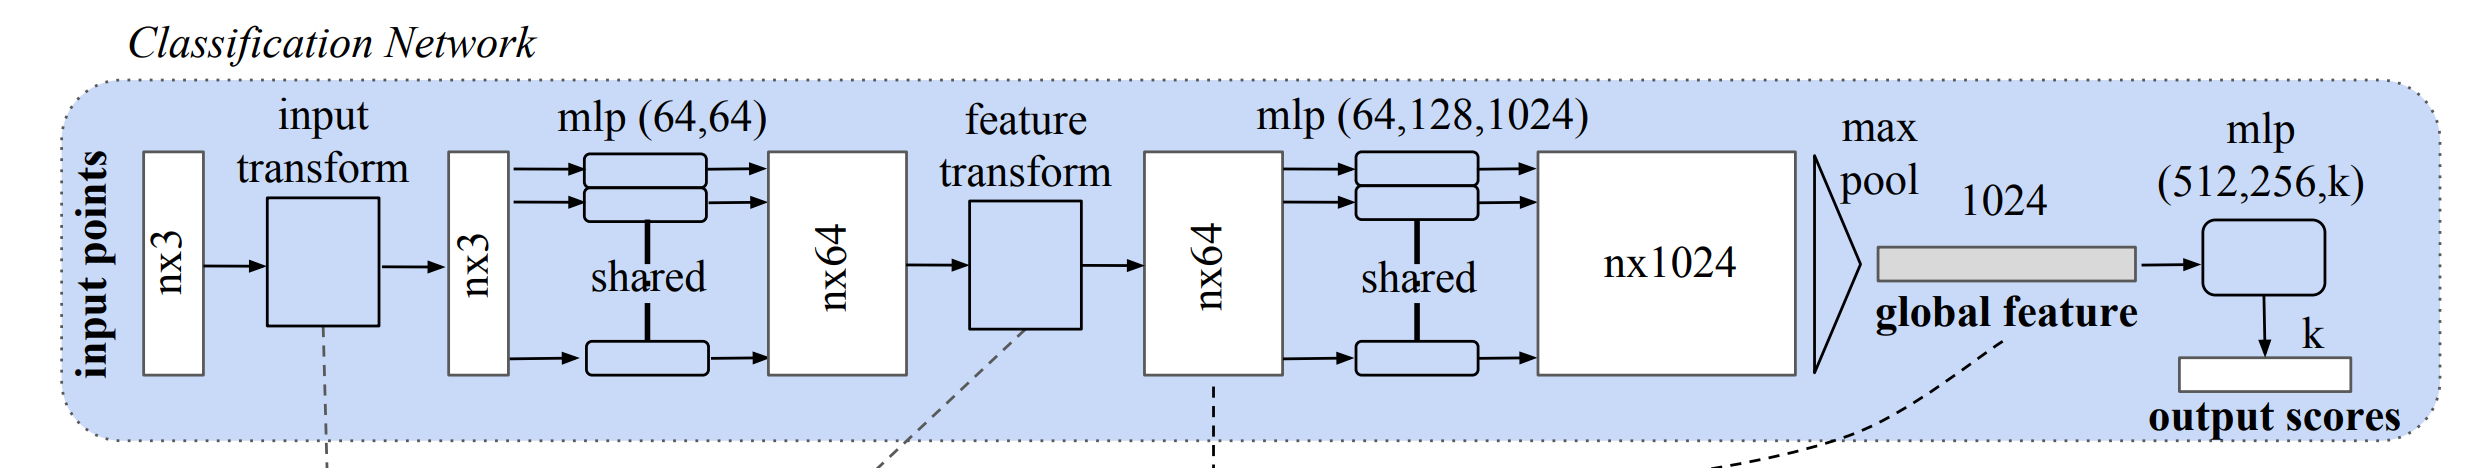

Note: we are going to implement a simplified PointNet; without T-Net (input/feature transform) as they are not that critical.

We will build the basic modules first which you **should use them** to build the simplified PointNet architecture.# ReLU 将负值设置为零，LeakyReLU 为负值引入一个小斜率，而 PReLU 允许在训练期间学习斜率。 ReLU 显示vanishing gradient等问题，则从 ReLU 开始并考虑将 LeakyReLU 作为替代方案.


In [10]:
def activation_layer(activation='relu', inplace=True, slope=0.2, prelu=1):
    """Get an activation function layer given the name"""
    activation = activation.lower()
    if activation in ('none', 'identity'):
        layer = nn.Identity()
    elif activation == 'relu':
        layer = nn.ReLU(inplace)
    elif activation == 'leakyrelu':
        layer = nn.LeakyReLU(slope, inplace)
    elif activation == 'prelu':
        layer = nn.PReLU(num_parameters=prelu, init=slope)
    else:
        raise ValueError(f'unknown activation layer [{activation}]')
    return layer

def mlp(*channels, bias=True, shared=False, norm=True, dropout=0, **kwargs):
    """Get a Multi-Layer Perceptron (MLP)

    if shared, it is implemented as Conv1d with kernel_size=1
    the input is a point cloud and the same linear layer is applied
    on each point independently. This can be in theory implemented
    as just Linear layer if the point cloud shape was [B, N, C]
    but we decided to implement it this way as an introduction to Part 2

    Args:
        channels: layer dimensions (e.g. [3, 64, 40] gives 2 layers)
        bias: whether to use bias or not
        shared: whether the input is a point cloud or global feature
        norm: whether to use batch norm or not
        dropout: the drop probability of dropout
        kwargs: options for the activation function

    Returns:
        nn.Sequential of the MLP's blocks 
    """
    modules = []
    for in_channels, out_channels in zip(channels, channels[1:]):
        block = []
        if norm:
            bias = False  # don't use bias if you are using batch norm  参数数量方面更加高效，学习到的偏差项可以抵消归一化操作，导致性能不佳。
        if shared:
            linear = nn.Conv1d(in_channels, out_channels, 1, bias=bias)
        else:
            linear = nn.Linear(in_channels, out_channels, bias)
        block.append(linear)
        
        # TODO: vvvvvvvvvv (0.5 points)
        # append normalizationm, activation layer, and dropout layer to the block
        if norm:
            block.append(torch.nn.BatchNorm1d(out_channels))
        block.append(activation_layer(**kwargs))
        if dropout > 0:
            block.append(torch.nn.Dropout(dropout))
        modules.append(nn.Sequential(*block))
    return nn.Sequential(*modules)

In [11]:
class SimplePointNet(nn.Module):
    def __init__(self, num_classes=40):
        super().__init__()
        # TODO: vvvvvvvvvvv (1 points)
        # build the PointNet w/o any transformation (T-Net)
        # no input transformation, no feature transformation
        
        # shared MLPs (per-point features)
        # input: [B, 3, N]
        # layers: 3 -> 64 -> 128 -> 1024
        # output: [B, 1024, N]
        # hint: using the mlp block to build
        self.shared = mlp(3, 64, 128, 1024, shared=True)

        self.pool = nn.Sequential(
                    nn.MaxPool1d(1024),  # pool over the points
                    nn.Flatten(1),
                    )
            
        # MLP classifier
        # input: [B, 1024]
        # layers: 1024 -> 512 -> 256 -> num_classes
        # output: [B, num_classes]
        # there is a dropout somewhere here
        # hint: using the mlp block with shared to False. 
        # hint: using sequential 
        # hint: be careful about dropout, normalziation, and activation layer
        self.classifier = mlp(1024, 512, 256, num_classes, shared=False, dropout=0.3, norm=True, activation='relu')
        # ^^^^^^^^^^^^^^^^^

    def forward(self, point_cloud):
        # TODO: vvvvvvvvvvv (0.5 points)
        # perform the forward pass
        x = self.shared(point_cloud)
        return self.classifier(self.pool(x))
        # ^^^^^^^^^^^^^^^^^

In [35]:
import torch.optim as optim

model = SimplePointNet().to(device)

# TODO: vvvvvvvvvv (1 point)
# use the same optimizer and learning scheduler as suggested in the paper
# run the training for 10 epochs
# goal: best weighted test recall should be over 50%
epochs = 10
log_dir = './runs/PointNet/experiment_1'
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)
# ^^^^^^^^^^^^^^^^^

train(model, loaders, optimizer, scheduler, device, epochs, log_dir)
del model, optimizer, scheduler

Already trained for 10 epochs!


**TODO (1.0 points)**: Attach a screenshot of the Loss and Recall tabs from TensorBoard in a text cell below:

<img src=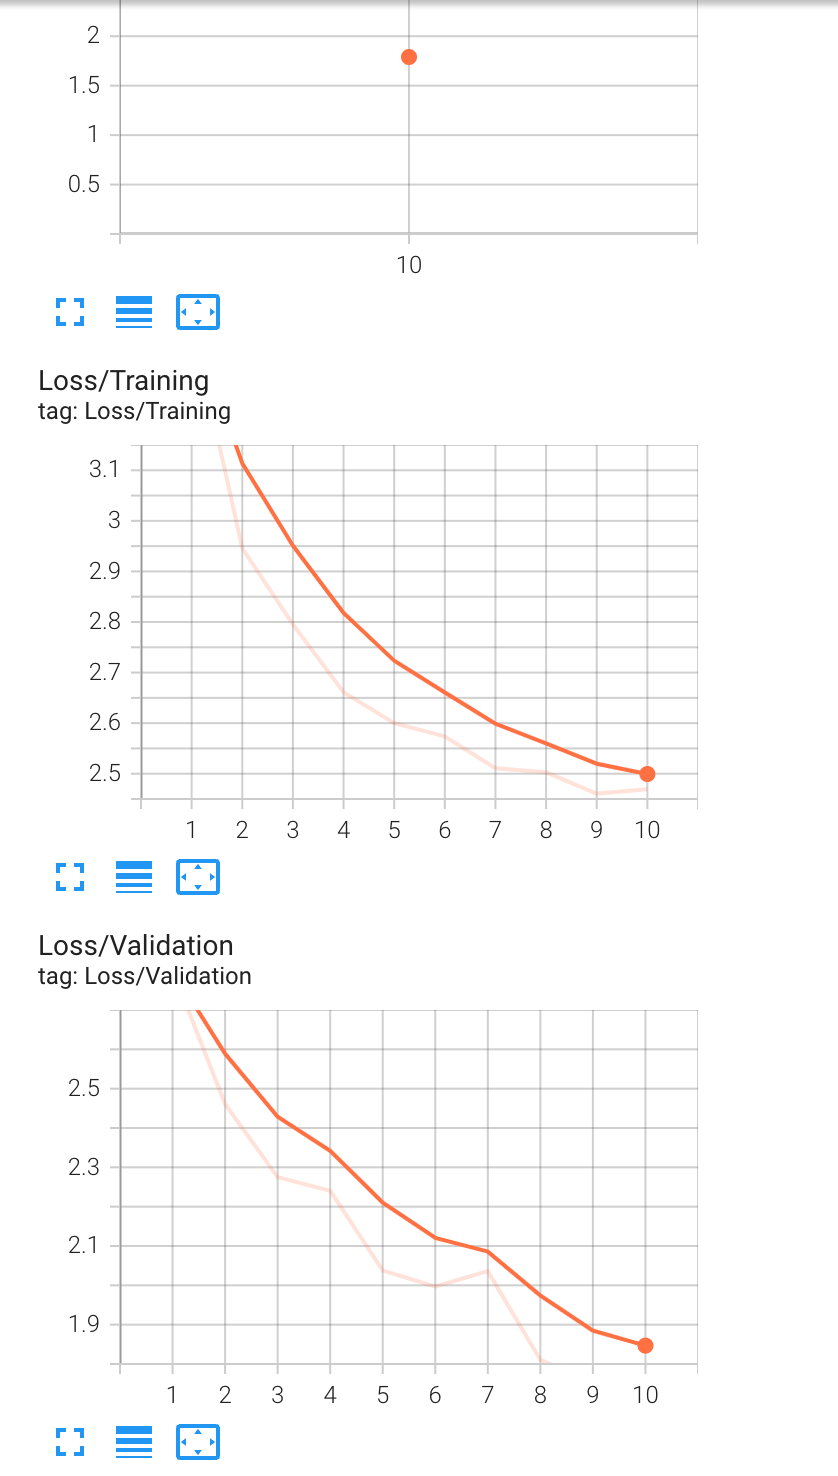 >

<img src=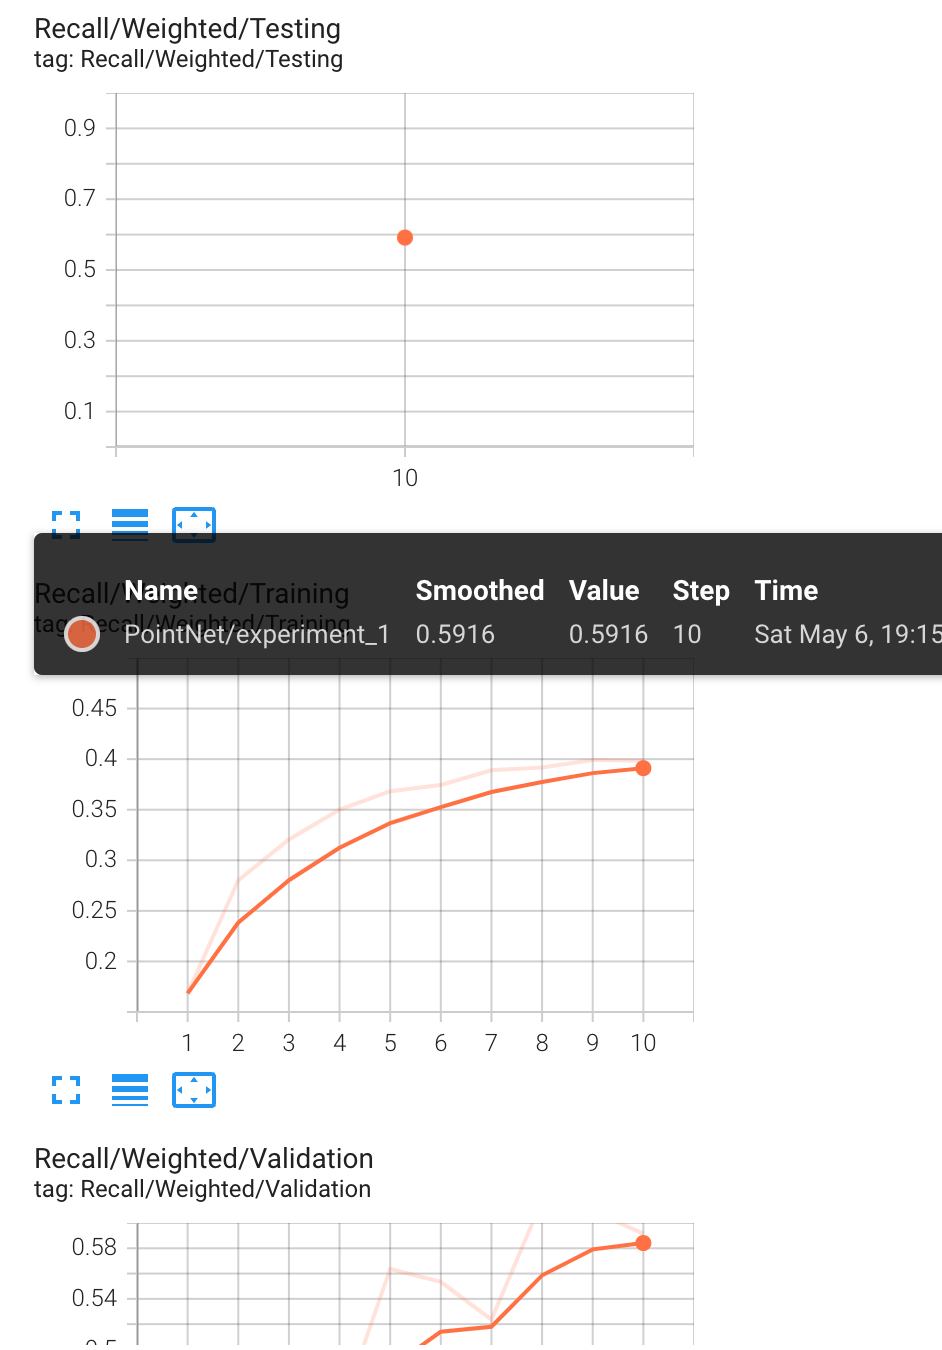 >

# Part 3: Graph Convolutional Networks (3.5 points)

The problem with PointNet is that no point can know about any other point until they reach the global pooling bottleneck. The shared MLPs prevent any comunication of information between the points. A better approach can be formulated in a [message passing framework](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html). In particular, we start thinking about our point cloud as a directed graph, where every point is a vertex (node) in the graph with edges connecting to the *neighbors* of the point. The way we define this neighborhood relationship is up to us but usually we just use the k-nearest neighbors (kNNs). Once we have represented the point cloud as a graph, we can just aggregate the features of the neighbors per-point. With this, we have the most basic building block of graph convolutional networks (GCNs):

$$\mathbf{x}_{i}^{\prime}=\gamma_{\mathbf{\Theta}}\left(\mathbf{x}_{i}, \square_{j \in \mathcal{N}(i)} \phi_{\Theta}\left(\mathbf{x}_{i}, \mathbf{x}_{j}, \mathbf{e}_{ji}\right)\right)$$

- where $\square$ denotes a differentiable, permutation invariant aggregation function (e.g., sum, mean or max)
- $\gamma_{\mathbf{\Theta}}$ and $\phi_{\Theta}$ denote permutation invariant differentiable functions such as MLPs and $1\times1$ convolutions
- $\mathbf{x}_i, \mathbf{x}_j, \mathbf{e}_{ji}$ is the center node, the neighbor node, and the edge from node $j$ to node $i$
- $\mathcal{N}(i)$ is the neighborhood of node $i$
- $\mathbf{x}_{i}^{\prime}$ is the output of node $i$

## Task 1: Edge Convolution (1.5 points)

Deep Graph Convolutional Neural Networks ([DGCNN](https://arxiv.org/abs/1801.07829)) have defined an example of such operation and called it EdgeConv:

$$\mathbf{x}_i^{\prime} = \max_{j \in \mathcal{N}(i)} h_{\mathbf{\Theta}} \left(\text{concat} \left[ \mathbf{x}_i, \mathbf{x}_j - \mathbf{x}_i \right] \right)$$

If we want to implement this, we can immediately see that the input is a point cloud $\mathbf{x}_i$ of shape `[B, C, N]` with the $K$ neighbors per point given by their indices $\mathcal{N}(i)$ of shape `[B, N, K]` and the output is the updated point cloud $\mathbf{x}_i^{\prime}$ of shape `[B, C', N]`. The only tricky part here is the edges $\mathbf{x}_j - \mathbf{x}_i$ which have the shape `[B, C, N, K]`. After the concatenation with $\mathbf{x}_i$, they become `[B, C + C, N, K]`. Then, $h_{\mathbf{\Theta}}$ will act on the channels producing `[B, C', N, K]`. Finally, the $\max$ is done over the neighbors which will give our desired output `[B, C', N]`. 取 邻居的最大值

*Note*: in a similar spirit to what we did in PointNet, we can leverage Conv2d with $1 \times 1$ kernel size here.

In [13]:
def cnn(*channels, bias=True, norm=True, dropout=0, **kwargs):
    """Get a 2D Convolutional Neural Network (CNN)

    Args:
        channels: layer dimensions (e.g. [3, 64, 40] gives 2 layers)
        bias: whether to use bias or not
        norm: whether to use batch norm or not
        dropout: the drop probability of dropout
        kwargs: options for the activation function

    Returns:
        nn.Sequential of the CNN's blocks 
    """
    # TODO: vvvvvvvvvvv (0.5 points)
    # build this in exactly similar manner to what we did with mlp
    # the only difference here is that we use Conv2d and BatchNorm2d
    # and it is always shared (we don't have nonshared mode)
    modules = []
    for in_channels, out_channels in zip(channels, channels[1:]):
        block = []
        if norm:
            bias = False  # don't use bias if you are using batch norm

        linear = nn.Conv2d(in_channels, out_channels, 1, bias=bias)
        block.append(linear)
    
        if norm:
            block.append(torch.nn.BatchNorm2d(out_channels))
        block.append(activation_layer(**kwargs))
        if dropout > 0:
            block.append(torch.nn.Dropout(dropout))
        modules.append(nn.Sequential(*block))
    return nn.Sequential(*modules)

# test
cnn(4 * 2, 12)
# ^^^^^^^^^^^^^^^^^

Sequential(
  (0): Sequential(
    (0): Conv2d(8, 12, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
)

In [14]:
def gather_features(features, indices, sparse_grad=False):
    """Gather the features specified by indices

    Args:
        features: tensor of shape [B, C, N]
        indices: long tensor of shape [B, N, K]
        sparse_grad: whether to use a sparse tensor for the gradient

    Returns:
        gathered_features [B, C, N, K]
    """
    features, indices = features.unsqueeze(-1), indices.unsqueeze(-3)
    features, indices = torch.broadcast_tensors(features, indices)
    return features.gather(dim=-2, index=indices, sparse_grad=sparse_grad)

In [15]:
class EdgeConv(nn.Module):
    """Static Edge Convolutional Layer"""
    def __init__(self, in_channels, out_channels, pool='max', **kwargs):
        super().__init__()
        pool = pool.lower()
        self.shared = cnn(in_channels * 2, out_channels, **kwargs)
        if pool == 'max':
            self.pool = lambda x: torch.max(x, dim=-1, keepdim=False)[0]
        elif pool in ['mean', 'avg']:
            self.pool = lambda x: torch.mean(x, dim=-1, keepdim=False)
        elif pool == 'sum':
            self.pool = lambda x: torch.sum(x, dim=-1, keepdim=False)
        else:
            raise NotImplementedError(f'reduction {self.reduction} not implemented')
            
    def forward(self, point_cloud, edge_index):
        """Perform the forward pass

        Args:
            point_cloud: tensor of shape [B, C, N]
            edge_index: tensor of shape [B, N, K]

        Returns:
            output point cloud of shape [B, C', N]
        """
        # TODO: vvvvvvvvvvv (1 points) 
        # Prepare x_i and x_j to do the forward pass correctly
        x_j = gather_features(point_cloud,edge_index)
        x_i = point_cloud.unsqueeze(-1).repeat(1, 1, 1, edge_index.shape[-1])

        # Compute the edge features and apply the shared convolutional network
        edge_features = torch.cat([x_i, x_j - x_i], dim=1)
        out = self.shared(edge_features)

        # Apply the pooling function along the K dimension
        out = self.pool(out)        
        
        return out


# TEST your EdgeConv here
point_cloud = torch.randn(7, 3, 1024)  # [B, C, N]
edge_index = torch.randint(1024, (7, 1024, 20))  # [B, N, K]  , 20 random neighbors
print(EdgeConv(3, 64)(point_cloud, edge_index).shape)  # [B, C', N]
del point_cloud, edge_index

torch.Size([7, 64, 1024])


## Task 2: Dynamic Edge Convolution (0.5 points)

The dynamic edge convolutional layer is simply a static EdgeConv with kNN as the neighborhood function. Dynamic Edge Conv queires neighbors before passing the point cloud into a static EdgeConv.

In [16]:
def get_neighbors(num_neighbors, features, neighbors=None, p_norm=2,
                  farthest=False, ordered=False):
    """Get the distances and indices to a fixed number of neighbors

    https://gist.github.com/ModarTensai/60fe0d0e3536adc28778448419908f47

    Args:
        num_neighbors: number of neighbors to consider
        features: query points which we need their neighbors [B, C, N]
        neighbors: set of support points (`features` if None) [B, C, M]
        p_norm: distances are computed based on L_p norm
        farthest: whether to get the farthest or the nearest neighbors
        ordered: distance sorted (descending if `farthest`)

    Returns:
        (distances, indices) both of shape [B, N, `num_neighbors`]
    """
    features = features.movedim(-1, -2)
    if neighbors is None:
        neighbors = features
    else:
        neighbors = neighbors.movedim(-1, -2)
    
    pairs = torch.cdist(features, neighbors, p_norm)
    return pairs.topk(num_neighbors, dim=-1, largest=farthest, sorted=ordered)

# TODO: test knn
pointcloud = torch.randn(7, 3, 1024)
support = torch.randn(7, 3, 2048)
get_neighbors(20, pointcloud, support).indices.shape

torch.Size([7, 1024, 20])

In [17]:
class DynEdgeConv(EdgeConv):
    """Dynamic Edge Convolutional Layer"""
    def __init__(self, in_channels, out_channels, num_neighbors=20,
                 pool='max', **kwargs):
        self.num_neighbors = num_neighbors
        super().__init__(in_channels, out_channels, pool=pool, **kwargs)

    def forward(self, point_cloud):
        # TODO: vvvvvvvvvvv (0.5 points) 
        # perform the forward pass of DynEdgeConv
        neighbors = get_neighbors(self.num_neighbors, point_cloud)
        knn_out = super().forward(point_cloud, neighbors.indices)
        return knn_out # inherit forward pass from EdgeConv
        # ^^^^^^^^^^^^^^^^^^


DynEdgeConv(3, 64)(torch.randn(7, 3, 1024)).shape

torch.Size([7, 64, 1024])

## Task 3: Simple DGCNN (1.5 points)

Instead of reimplementing DGCNN, lets simply replace the shared MLP layers in the backbone of PointNet with DynEdgeConv.

In [18]:
class SimpleDGCNN(SimplePointNet):
    def __init__(self, num_classes=40):
        super().__init__(num_classes)
        # TODO: vvvvvvvvvvv (1 points)
        # replace shared MLPs with DynEdgeConv
        # input: [B, 3, N]
        # layers: 3 -> 64 -> 128 -> 1024
        # output: [B, 1024, N]
        self.shared = nn.Sequential(
            DynEdgeConv(3, 64),
            DynEdgeConv(64, 128),
            DynEdgeConv(128, 1024)
        )
        # ^^^^^^^^^^^^^^^^^
        # do not write anything else. SimpleDGCNN inherite most of the parts from SimplePointNet

out = SimpleDGCNN()(torch.randn(7, 3, 1024))
print(out.shape)

torch.Size([7, 40])


In [19]:
# set device to cuda
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'using {device}...')


# create train_loader and test_loader for ModelNet40

# just copy from Part 1.
# you might need a smaller batch size like B=8
train_loader =  torch.utils.data.DataLoader( train_set, batch_size=32, shuffle=True, num_workers=2)
test_loader =  torch.utils.data.DataLoader( test_set, batch_size=32, shuffle=True, num_workers=2)

class Phase(enum.Enum):
    TRAINING = TRAIN = enum.auto()
    VALIDATION = VALID = VAL = enum.auto()
    TESTING = TEST = enum.auto()


loaders = {
    Phase.TRAINING: train_loader,
    Phase.VALIDATION: test_loader,
    Phase.TESTING: test_loader,
}
# ^^^^^^^^^^^^^^^^^

using cuda:0...


In [20]:
# decrease the batch size if you encounter out of memory issue
model = SimpleDGCNN().to(device)

# TODO: vvvvvvvvvvv (0.5 points)
# use the same optimizer and learning scheduler as we did in PointNet
# run the training for at least 10 epochs
# soft goal: best weighted test recall should be over 50%
epochs = 10
log_dir = './runs/DGCNN/experiment_1'
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.75)
# ^^^^^^^^^^^^^^^^^

train(model, loaders, optimizer, scheduler, device, epochs, log_dir)
del model, optimizer, scheduler

PyTorch version: 1.10.0
Is debug build: False
CUDA used to build PyTorch: 11.3
ROCM used to build PyTorch: N/A

OS: Ubuntu 18.04.5 LTS (x86_64)
GCC version: (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Clang version: Could not collect
CMake version: Could not collect
Libc version: glibc-2.17

Python version: 3.7.11 (default, Jul 27 2021, 14:32:16)  [GCC 7.5.0] (64-bit runtime)
Python platform: Linux-4.15.0-167-generic-x86_64-with-debian-buster-sid
Is CUDA available: True
CUDA runtime version: 11.3.109
GPU models and configuration: 
GPU 0: Tesla V100-SXM2-16GB
GPU 1: Tesla V100-SXM2-16GB
GPU 2: Tesla V100-SXM2-16GB

Nvidia driver version: 515.65.01
cuDNN version: Probably one of the following:
/usr/lib/x86_64-linux-gnu/libcudnn.so.8.2.0
/usr/lib/x86_64-linux-gnu/libcudnn_adv_infer.so.8.2.0
/usr/lib/x86_64-linux-gnu/libcudnn_adv_train.so.8.2.0
/usr/lib/x86_64-linux-gnu/libcudnn_cnn_infer.so.8.2.0
/usr/lib/x86_64-linux-gnu/libcudnn_cnn_train.so.8.2.0
/usr/lib/x86_64-linux-gnu/libcudnn_ops_infer.so

  0%|          | 0/308 [00:00<?, ?it/s]

loss = 2.08764 (averaged over 9840 samples)
              recall precision  f1_score       iou
      mean    42.57%    41.69%    41.91%    27.84%
  weighted    50.29%    50.58%    50.29%    34.94%
Epoch: 10 (VALIDATION)#################################


  0%|          | 0/78 [00:00<?, ?it/s]

loss = 1.38859 (averaged over 2468 samples)
              recall precision  f1_score       iou
      mean    65.21%    65.99%    61.60%    50.05%
  weighted    72.77%    76.16%    71.18%    59.71%
Epoch: 9 (TESTING)    #################################


  0%|          | 0/78 [00:00<?, ?it/s]

loss = 1.33942 (averaged over 2468 samples)
              recall precision  f1_score       iou
      mean    65.66%    68.43%    63.82%    51.89%
  weighted    74.51%    76.61%    73.67%    62.22%


<img src = "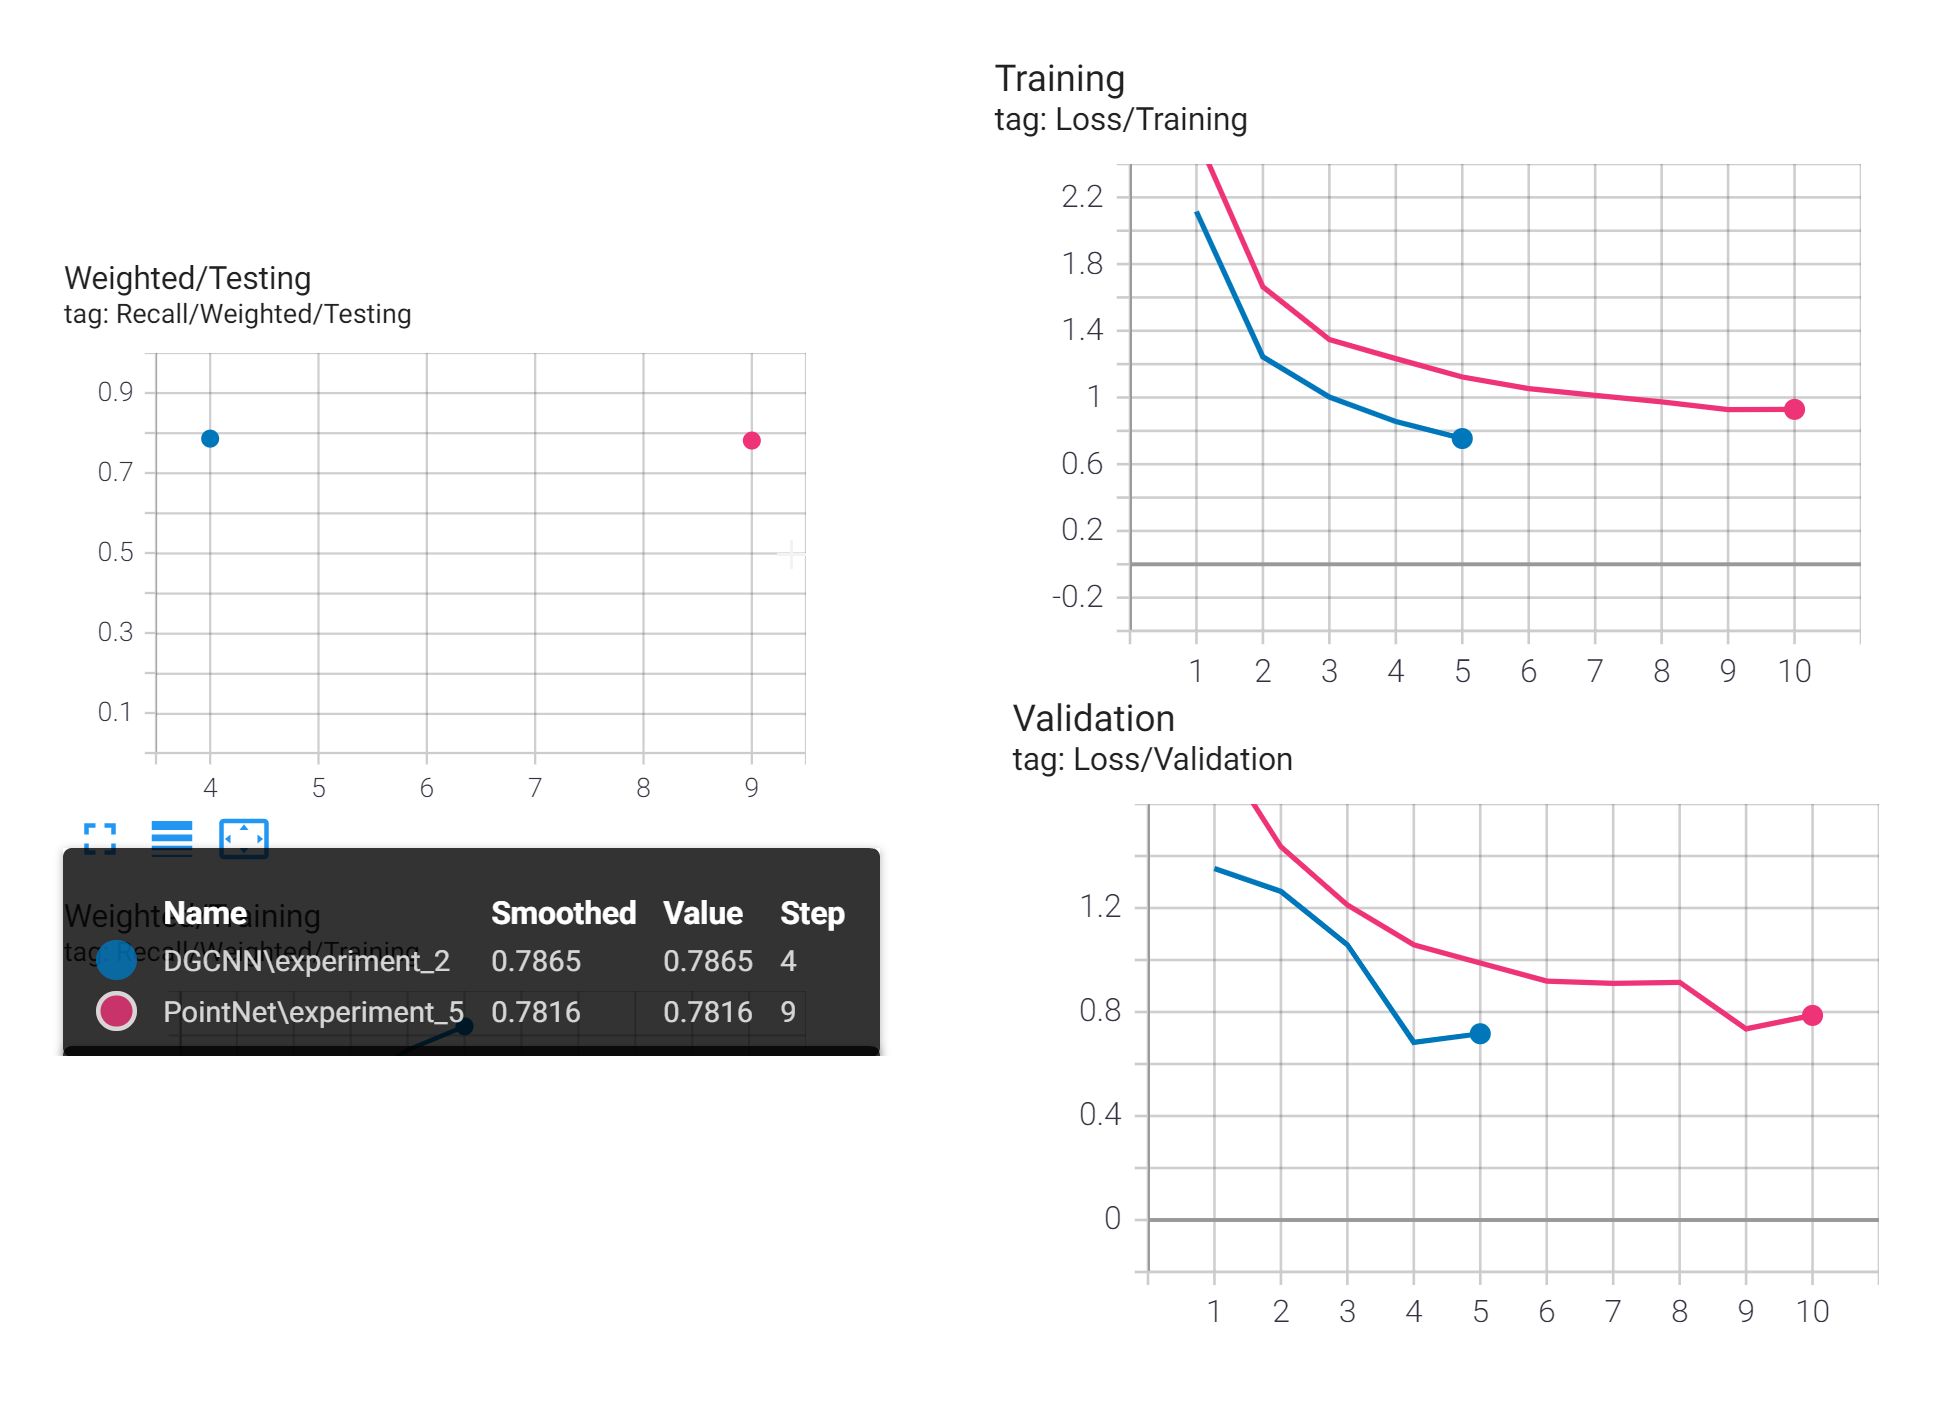
"/>

**TODO**: Attach a screenshot of the Loss and Recall tabs from TensorBoard in a text cell below:

<img src = " 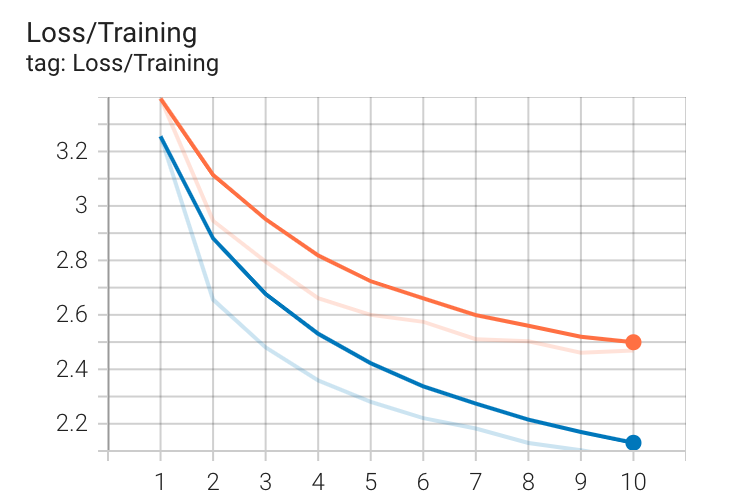"/>

<img src = "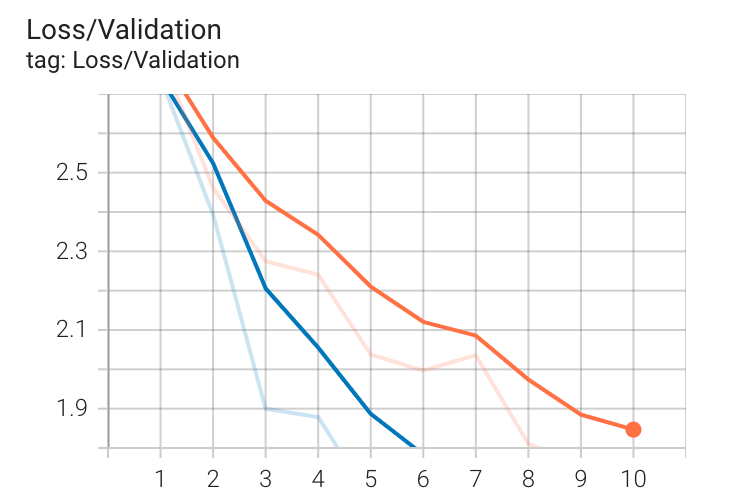 "/>

<img src = "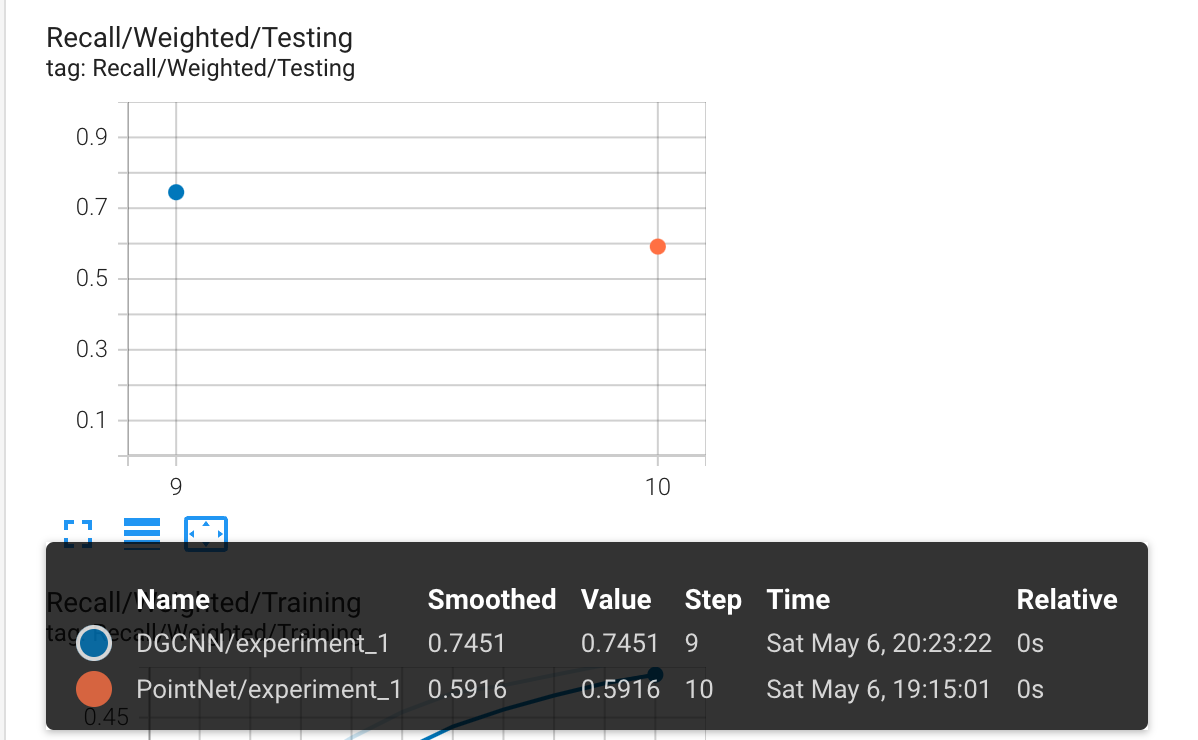 "/>

<!-- screenshot goes here -->

# Part 4: Zero-shot Point Cloud Classification using CLIP (1.5 points)

[CLIP](https://arxiv.org/pdf/2103.00020.pdf) (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task, similarly to the zero-shot capabilities of GPT-2 and 3. CLIP is able to match the performance of the original ResNet50 on ImageNet “zero-shot” without using any of the original 1.28M labeled examples, overcoming several major challenges in computer vision.

<img src=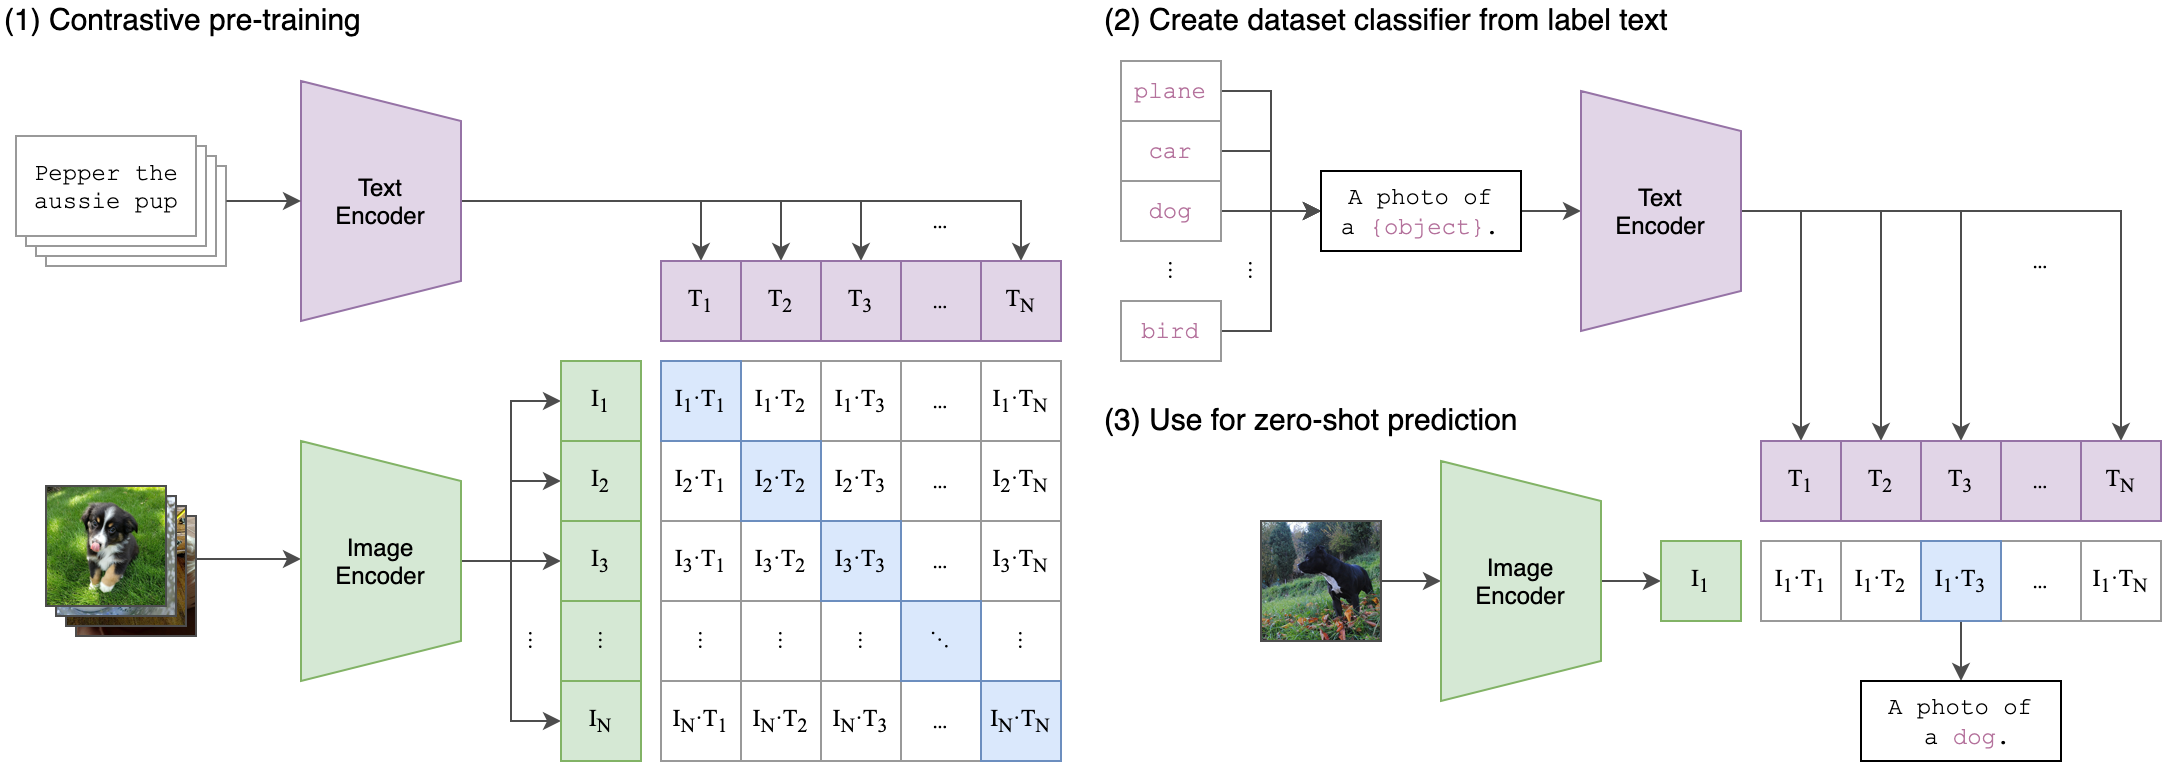 width=1024>

## Task 1: A Toy Version of PointCLIP (1.5 Point)

We are going to ultize the zero-shot ability of CLIP for point cloud classification without any labelling. The idea of using CLIP for point cloud classificaiton was firstly proposed in [PointCLIP](https://arxiv.org/abs/2112.02413) paper in Dec 2021. We encourge the students to read the [CLIP blog](https://openai.com/blog/clip/), [the colab demo of CLIP](https://github.com/openai/CLIP) and the most relevent [PointCLIP](https://arxiv.org/abs/2112.02413) paper before moving on to the following tasks. 

<img src= width=1024>

As a part in a course project, we do not require to implement the whole framework of PointCLIP. Instead, we just work on a single view version without any training on the target dataset. Further, we do not require testing PointCLIP on all pointclouds, we just try it out on one simple sample, a random sample from the airplane class. Even more, we do not require the students to write a rendering function to render an image from the point cloud as done in [MVTN](https://github.com/ajhamdi/MVTN), instead I provide a simple screenshot of the point cloud. 是用一个image 放进去看和哪个text最接近.  不会经过inter view adapter. 因为没有label.

In [21]:
import numpy as np
import torch
from pkg_resources import packaging
from PIL import Image, ImageOps
import clip

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [23]:
# download image
!gdown https://drive.google.com/uc?id=1m9ychgioKZqrUanxQpp8kbYgQcFqEoH5

Downloading...
From: https://drive.google.com/uc?id=1m9ychgioKZqrUanxQpp8kbYgQcFqEoH5
To: /root/share/cs323/airplane.png
100%|█████████████████████████████████████████| 106k/106k [00:00<00:00, 413kB/s]


In [32]:
# open a random view of point cloud
im = Image.open("airplane.png")
image =  preprocess(im).to(device)  # pre-process images (check CLIP demo)

In [33]:
# TODO: CLIP for zero-shot point cloud classification (1.5 points)

text_descriptions = test_set.classes
print(text_descriptions)
text_tokens = clip.tokenize(text_descriptions).to(device)


with torch.no_grad():
    image_features = model.encode_image(image.unsqueeze(0)).float()  
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)
top_probs = top_probs.numpy()
top_labels = top_labels.numpy()

['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone', 'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp', 'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink', 'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']


[0 1 2 3 4]
[1.0000000e+00 4.8328573e-18 1.7484766e-18 8.5982500e-21 1.6911851e-21]


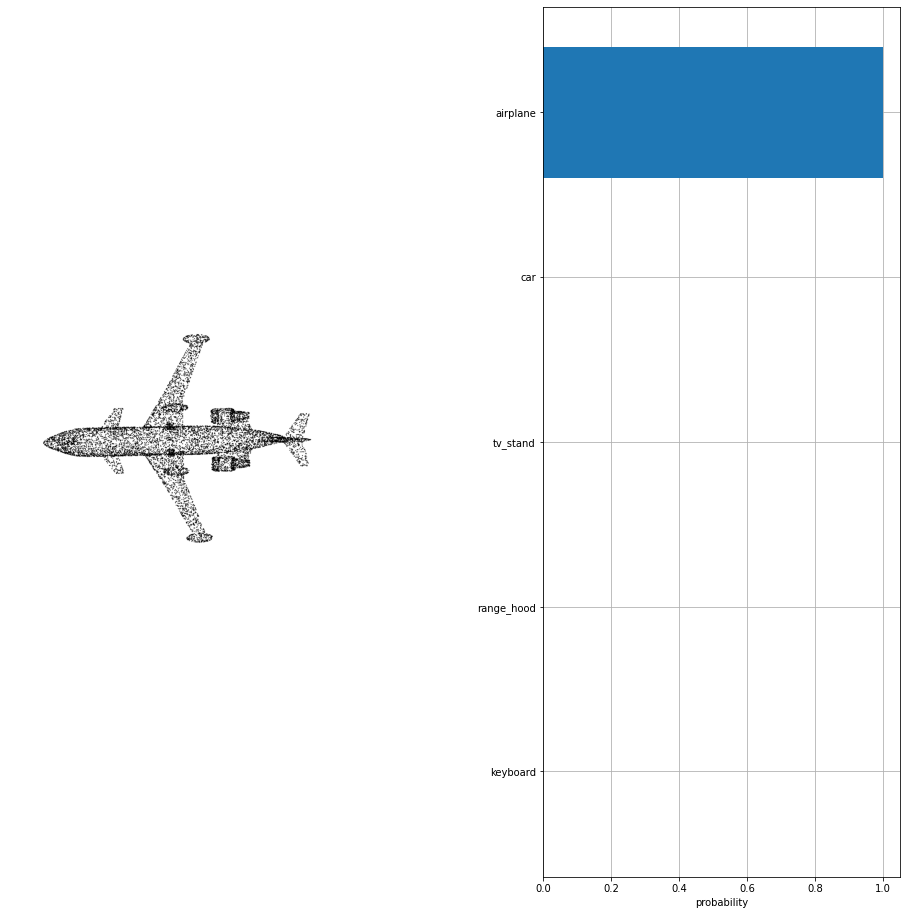

In [31]:
# visulize results
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))

plt.subplot(1, 2, 1)
plt.imshow(im)
plt.axis("off")

plt.subplot(1, 2, 2)
y = np.arange(top_probs.shape[-1])
plt.grid()
print(y)
print(top_probs[0])
plt.barh(y, top_probs[0])
plt.gca().invert_yaxis()
plt.gca().set_axisbelow(True)
plt.yticks(y, [test_set.classes[index] for index in top_labels[0]])
plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

TODO: Congrats on fininshing the coding part. For the purpose of assesement,  please do not delete the output from each cell. Also, the students should prepare for the questions related to PointNet, message passing, DGCNN, CLIP, and Point-CLIP. 

# Concluding Remark

I hope these projects gave you a hands-on experience with deep learning. Now is definitely an [exciting time for AI](https://spectrum.ieee.org/the-institute/ieee-member-news/stop-calling-everything-ai-machinelearning-pioneer-says.amp.html). We barely scratched the surface but the posibilities are wide open. If you want to see what else is out there, maybe start with [reinforcement learning](https://www.youtube.com/watch?v=93M1l_nrhpQ&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=5) and self-supervised learning.